In [23]:
import numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [29]:
class HalfInning():
    
    """
    Characterize the state of play of a half-inning, and how transitions occur.
    
    'Baseball Assumptions':
    1) Runners on first, second, or third score on a double
    2) Runners on second and third score on a single, but runner on 1st DOES NOT advance to third
    3) Runner on third scores on a fly out (<2 outs), but no one else advances
    4) No runners score or advance on "foul out"
    5) All runners advance on "out at first" (<2 outs)
    6) Double play with no one on is same as out at first
    7) Double play with 2+ runners on: lead runner and batter are out
    """
    
    def __init__(self):
        self.runs_scored = 0
        self.outs = 0
        self.on_first = False
        self.on_second = False
        self.on_third = False
        
    def still_playing(self):
        """
        At the end of each play, check all properties are valid, and return
        True/False if the inning is still ongoing
        """
        if (not isinstance(self.runs_scored, int)) or (self.runs_scored < 0):
            raise ValueError(f'Invalid runs_scored: {self.runs_scored}')
        if (not isinstance(self.outs, int)) or (self.outs > 3) or (self.outs < 0):
            raise ValueError(f'Invalid outs: {self.outs}')
        if not isinstance(self.on_first, bool):
            raise ValueError(f'Invalid on_first: {self.on_first}')
        if not isinstance(self.on_second, bool):
            raise ValueError(f'Invalid on_second: {self.on_second}')
        if not isinstance(self.on_first, bool):
            raise ValueError(f'Invalid on_third: {self.on_third}')
        return (self.outs < 3)
        
    def single(self):
        """
        Runners on second & third score on single
        Runner on first DOES NOT advance to third
        """
        for state in ['on_third', 'on_second']:
            if getattr(self, state, 'False'):
                self.runs_scored += 1
            setattr(self, state, False)
        if self.on_first:
            self.on_second = True
        self.on_first = True
        return self.still_playing()
        
    def double(self):
        """
        All runners on base score on a double
        """
        for state in ['on_third', 'on_second', 'on_first']:
            if getattr(self, state, 'False'):
                self.runs_scored += 1
            setattr(self, state, False)
        self.on_second = True
        return self.still_playing()
        
    def triple(self):
        """
        All runners on base score on a triple
        """
        for state in ['on_third', 'on_second', 'on_first']:
            if getattr(self, state, 'False'):
                self.runs_scored += 1
            setattr(self, state, False)
        self.on_third = True
        return self.still_playing()
        
    def home_run(self):
        """
        Everyone goes home
        """
        self.runs_scored += 1
        for state in ['on_third', 'on_second', 'on_first']:
            if getattr(self, state, 'False'):
                self.runs_scored += 1
            setattr(self, state, False)
        return self.still_playing()
            
    def base_on_balls(self):
        """
        Everyone advances one base
        """
        if self.on_third:
            self.runs_scored += 1
            self.on_third = False
        if self.on_second:
            self.on_third, self.on_second = True, False
        if self.on_first:
            self.on_second, self.on_first = True, False
        self.on_first = True
        return self.still_playing()

    def base_on_error(self):
        """
        Everyone advances one base
        """
        return self.base_on_balls()
        
    def strike_out(self):
        """
        Adds an out
        """
        self.outs += 1
        return self.still_playing()
    
    def foul_out(self):
        """
        Adds an out. No one advances.
        """
        self.outs += 1
        return self.still_playing()
    
    def out_at_first(self):
        """
        Adds an out, and all runners advance
        """
        self.outs += 1
        if self.outs < 3:
            if self.on_third:
                self.runs_scored += 1
                self.on_third = False
            if self.on_second:
                self.on_third, self.on_second = True, False
            if self.on_first:
                self.on_second, self.on_first = True, False
        return self.still_playing()
    
    def fly_out(self):
        """
        Adds an out. Runner on third scores but no one else advances
        """
        self.outs += 1
        if (self.outs < 3) and (self.on_third):
            self.runs_scored += 1
            self.on_third = False
        return self.still_playing()
    
    def double_play(self):
        """
        If no one on base, counts as a single out.
        
        If multiple runners on base, lead runner and batter are out, others advance.
        """
        if self.outs == 2:
            self.outs = 3
            return self.still_playing()
        if self.on_third:
            self.outs += 2
            self.on_third = False
            if self.on_second:
                self.on_third, self.on_second = True, False
            if self.on_first:
                self.on_second, self.on_first = True, False
        elif self.on_second:
            self.outs += 2
            self.on_second = False
            if self.on_first:
                self.on_second, self.on_first = True, False
        elif self.on_first:
            self.outs += 2
            self.on_first = False
        else:
            self.outs += 1
        self.on_first = False
        return self.still_playing()

In [31]:
def make_play(halfinning):
    """
    Roll two sets of dice and update the halfinning by the resulting play
    """
    a,b = np.random.randint(low=1, high=7, size=2)
    doubles = [(1,1)]
    singles = [(1,2), (1,3), (1,4)]
    error = [(1,5)]
    walk = [(1,6)]
    k = [(2,2), (2,3), (2,4), (2,5)]
    foul = [(2,6)]
    out1st = [(3,3), (3,4), (3,5), (3,6)]
    flyout = [(4,4), (4,5), (4,6)]
    doubleplay = [(5,5)]
    triple = [(5,6)]
    hr = [(6,6)]
    if ((a,b) in doubles) or ((b,a) in doubles):
        return halfinning.double()
    elif ((a,b) in singles) or ((b,a) in singles):
        return halfinning.single()
    elif ((a,b) in error) or ((b,a) in error):
        return halfinning.base_on_error()
    elif ((a,b) in walk) or ((b,a) in walk):
        return halfinning.base_on_balls()
    elif ((a,b) in k) or ((b,a) in k):
        return halfinning.strike_out()
    elif ((a,b) in foul) or ((b,a) in foul):
        return halfinning.foul_out()
    elif ((a,b) in out1st) or ((b,a) in out1st):
        return halfinning.out_at_first()
    elif ((a,b) in flyout) or ((b,a) in flyout):
        return halfinning.fly_out()
    elif ((a,b) in doubleplay) or ((b,a) in doubleplay):
        return halfinning.double_play()
    elif ((a,b) in triple) or ((b,a) in triple):
        return halfinning.triple()
    elif ((a,b) in hr) or ((b,a) in hr):
        return halfinning.home_run()
    else:
        return ValueError(f'No valid result for rolls {a,b}')  # Should never reach here

In [16]:
def simulate_game(innings=9):
    """
    Simulate 18 half-innings of a game
    """
    runs = 0
    plays = 0
    for i in range(2*innings):
        half_inning = HalfInning()
        while half_inning.still_playing():
            plays += 1
            make_play(half_inning)
        runs += half_inning.runs_scored
    return runs, plays

In [24]:
runs, plays = [], []
for i in tqdm(range(10000)):
    r, p = simulate_game()
    runs.append(r)
    plays.append(p)

100%|██████████| 10000/10000 [00:12<00:00, 777.98it/s]


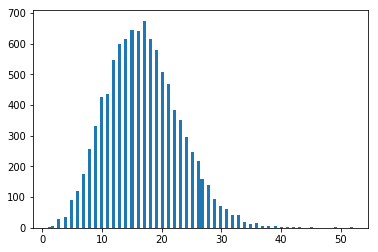

In [26]:
plt.hist(runs, bins=100);

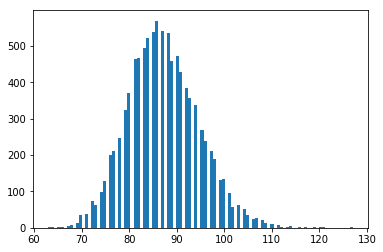

In [28]:
plt.hist(plays, bins=100);